# Herschel Stripe 82 master catalogue
## Preparation of SDSS Stripe 82 - IAC Legacy Survey data

This catalogue comes from `dmu0_IAC_Stripe82_Legacy_Project`.

One must choose between this catalogue and the official SDSS catalogue in 'dmu0_SDSS-S82'. Currently we choose this one.

In the catalogue, we keep:

- We generate a unique object identifier;
- The position;
- The u, g, r, i, z, aperture magnitude (for now in 3”);
- The u, g, r, i, z, auto fluxes and magnitudes.


We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates_tiled
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "sdss_ra"
DEC_COL = "sdss_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        #"objID": "sdss_id",
        "ALPHA_J2000": "sdss_ra",
        "DELTA_J2000": "sdss_dec",
        #"flags": "flags",
        "stellarity": "sdss_stellarity",
        "u_MAG_AUTO": "m_sdss_u",
        "g_MAG_AUTO": "m_sdss_g",
        "r_MAG_AUTO": "m_sdss_r",
        "i_MAG_AUTO": "m_sdss_i",
        "z_MAG_AUTO": "m_sdss_z",
        "u_MAGERR_AUTO": "merr_sdss_u",
        "g_MAGERR_AUTO": "merr_sdss_g",
        "r_MAGERR_AUTO": "merr_sdss_r",
        "i_MAGERR_AUTO": "merr_sdss_i",
        "z_MAGERR_AUTO": "merr_sdss_z",
        "u_MAG_APER_1": "m_ap_sdss_u",
        "g_MAG_APER_1": "m_ap_sdss_g",
        "r_MAG_APER_1": "m_ap_sdss_r",
        "i_MAG_APER_1": "m_ap_sdss_i",
        "z_MAG_APER_1": "m_ap_sdss_z",
        "u_MAGERR_APER_1": "merr_ap_sdss_u",
        "g_MAGERR_APER_1": "merr_ap_sdss_g",
        "r_MAGERR_APER_1": "merr_ap_sdss_r",
        "i_MAGERR_APER_1": "merr_ap_sdss_i",
        "z_MAGERR_APER_1": "merr_ap_sdss_z"        
    })


catalogue = Table.read(
    "../../dmu0/dmu0_IAC_Stripe82_Legacy_Project/data/iac_stripe82_concat_helpcoverage.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

catalogue.add_column(Column(data=np.arange(len(catalogue)), name='sdss_id', dtype=int))
    
epoch = 2013

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        mask = catalogue[col] > 90.
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if 'ap' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        


In [6]:
catalogue[:10].show_in_notebook()

idx,sdss_ra,sdss_dec,sdss_stellarity,m_sdss_u,m_sdss_g,m_sdss_r,m_sdss_i,m_sdss_z,merr_sdss_u,merr_sdss_g,merr_sdss_r,merr_sdss_i,merr_sdss_z,m_ap_sdss_u,m_ap_sdss_g,m_ap_sdss_r,m_ap_sdss_i,m_ap_sdss_z,merr_ap_sdss_u,merr_ap_sdss_g,merr_ap_sdss_r,merr_ap_sdss_i,merr_ap_sdss_z,sdss_id,f_sdss_u,ferr_sdss_u,flag_sdss_u,f_sdss_g,ferr_sdss_g,flag_sdss_g,f_sdss_r,ferr_sdss_r,flag_sdss_r,f_sdss_i,ferr_sdss_i,flag_sdss_i,f_sdss_z,ferr_sdss_z,flag_sdss_z,f_ap_sdss_u,ferr_ap_sdss_u,f_ap_sdss_g,ferr_ap_sdss_g,f_ap_sdss_r,ferr_ap_sdss_r,f_ap_sdss_i,ferr_ap_sdss_i,f_ap_sdss_z,ferr_ap_sdss_z
,deg,deg,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7.9e-06,-0.6811598,0.0,22.7434,22.179,21.1283,20.7023,20.444,0.1829,0.0461,0.0295,0.0282,0.0741,24.1723,23.28,22.0792,21.6507,21.375,0.2664,0.0587,0.0346,0.0303,0.0739,0,2.90161641856,0.488797960895,False,4.87977727286,0.20719372836,False,12.8433997455,0.348961645409,False,19.0142850374,0.49386106469,False,24.1212605609,1.64624279796,False,0.77817988387,0.190936914652,1.77010895832,0.0957004062293,5.3495838612,0.170479349207,7.93816277439,0.221532938673,10.2329299228,0.696498392502
1,1.2e-05,-0.441853,0.0,25.0592,23.9242,23.8076,23.4974,23.7606,0.983,0.1462,0.1898,0.2078,0.9601,25.0027,24.5206,24.3087,23.9264,24.0102,0.4803,0.1326,0.1499,0.1481,0.5567,1,0.343811184035,0.311278552217,False,0.977957541293,0.131687045076,False,1.08882980378,0.190340799038,False,1.44890529651,0.277307249491,False,1.13699878343,1.00543071806,False,0.362176276936,0.160216878695,0.56462486535,0.0689571341706,0.686309483403,0.0947539477005,0.975977936781,0.133128407991,0.903483030668,0.463251571578
2,1.63e-05,-0.1693558,0.0,23.4305,22.7872,21.9994,21.5573,21.4121,0.2593,0.0585,0.0442,0.0417,0.1351,23.8616,23.3131,22.5056,22.025,21.9832,0.2215,0.0587,0.0435,0.0394,0.1217,2,1.54099063711,0.368025741843,False,2.78689110872,0.150159061792,False,5.75758025081,0.234389390324,False,8.65127266431,0.332270461757,False,9.88917358172,1.2305266648,False,1.03600058347,0.211353483684,1.71695929817,0.0928268859053,3.61210195344,0.144718794755,5.6234132519,0.204066587403,5.84413177557,0.655067809262
3,3.03e-05,-0.1535,1.0,25.461,24.6486,23.762,23.8432,27.7665,1.1277,0.2041,0.1428,0.2138,31.4209,25.8624,25.1405,24.1513,23.9232,24.3767,1.0369,0.2095,0.1356,0.1529,0.8792,3,0.237465214365,0.246643264788,False,0.501833905164,0.0943362665766,False,1.13553362784,0.149349539368,False,1.05370732713,0.207492967033,False,0.0284053405254,0.822042555275,False,0.164074088406,0.156694067604,0.319006843598,0.0615544857405,0.793377719542,0.0990867010775,0.978858688406,0.137848855736,0.644644081878,0.52201545302
4,4.24e-05,-0.1919793,0.0,23.6244,23.4632,22.7811,22.486,22.5915,0.2669,0.0879,0.0721,0.0771,0.3245,24.0888,23.9069,23.1105,22.8286,22.87,0.256,0.0854,0.0638,0.0668,0.2414,4,1.28896166145,0.316857691521,False,1.49527130822,0.121055508158,False,2.80259278742,0.186110529508,False,3.67790070422,0.261174070693,False,3.33733651305,0.997448269422,False,0.840388304897,0.198150715718,0.993665016302,0.0781580203555,2.06918823295,0.121589580124,2.68262520038,0.165048713122,2.58226019063,0.574133576174
5,4.79e-05,0.0104786,0.0,28.7271,24.7754,24.352,24.5675,22.1077,32.7486,0.3133,0.3487,0.6433,0.287,nan,25.7483,24.896,25.092,23.7945,nan,0.3349,0.254,0.444,0.5647,5,0.0117262729784,0.353694591354,False,0.446519058144,0.128847523278,False,0.659477525949,0.211800815236,False,0.540754322946,0.320397583157,False,5.21098712333,1.37745549779,False,9.12010839356e-31,8.31593095087e-29,0.182255230129,0.056217409259,0.399576556619,0.0934779967145,0.333579996662,0.136413907788,1.10204670396,0.573183219829
6,4.91e-05,-0.6033114,0.0,24.3905,23.9676,24.0844,22.8704,22.5319,0.7538,0.2047,0.3356,0.1655,0.4444,26.2667,24.776,24.5654,23.9495,25.7836,1.3571,0.1599,0.1836,0.1509,2.726,6,0.636502333247,0.441907948449,False,0.939636762835,0.177155044208,False,0.843800930571,0.260818043148,False,2.58130902604,0.39347185986

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
import logging
logging.basicConfig(level=logging.INFO)

In [8]:
SORT_COLS = []
FLAG_NAME = 'sdss_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates_tiled(
    catalogue, RA_COL, DEC_COL, 
    sort_col= SORT_COLS,
    flag_name=FLAG_NAME,
    near_ra0=True)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

INFO:herschelhelp_internal.masterlist:The catalogue is divided in 37 x 3 (RA, Dec) tiles
INFO:herschelhelp_internal.masterlist:Processing RA between -0.000355 and 0.999645, and Dec between -1.250358 and -0.250358
INFO:herschelhelp_internal.masterlist:Processing RA between -0.000355 and 0.999645, and Dec between -0.250358 and 0.749642
INFO:herschelhelp_internal.masterlist:Processing RA between -0.000355 and 0.999645, and Dec between 0.749642 and 1.749642
INFO:herschelhelp_internal.masterlist:Processing RA between 0.999645 and 1.999645, and Dec between -1.250358 and -0.250358
INFO:herschelhelp_internal.masterlist:Processing RA between 0.999645 and 1.999645, and Dec between -0.250358 and 0.749642
INFO:herschelhelp_internal.masterlist:Processing RA between 0.999645 and 1.999645, and Dec between 0.749642 and 1.749642
INFO:herschelhelp_internal.masterlist:Processing RA between 1.999645 and 2.999645, and Dec between -1.250358 and -0.250358
INFO:herschelhelp_internal.masterlist:Processing RA b

The initial catalogue had 5290888 sources.
The cleaned catalogue has 5279317 sources (11571 removed).
The cleaned catalogue has 11560 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Herschel-Stripe-82.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

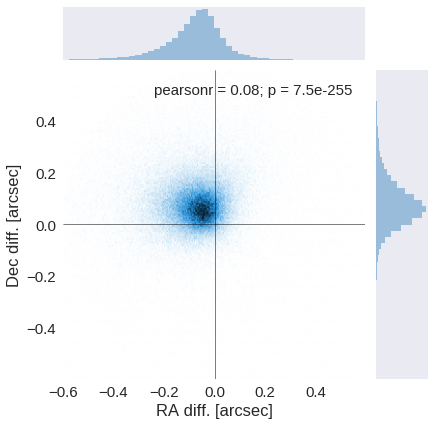

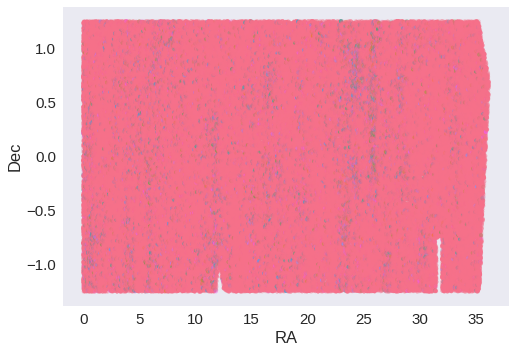

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.06390892208401056 arcsec
Dec correction: -0.0685382447484173 arcsec


In [12]:
catalogue[RA_COL] = catalogue[RA_COL] +  delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL] + delta_dec.to(u.deg)

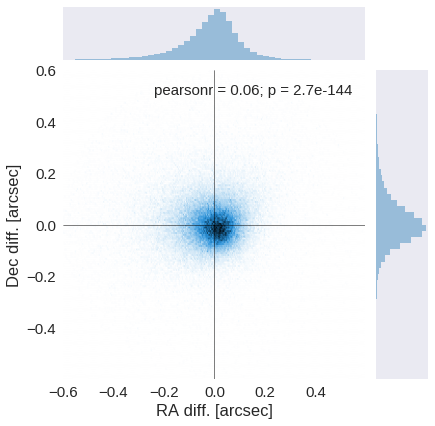

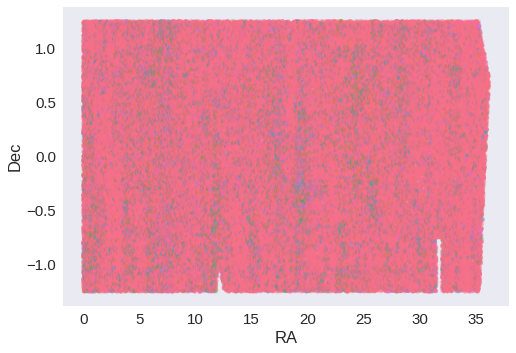

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "sdss_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

184058 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [16]:
catalogue.write("{}/SDSS-S82_IAC.fits".format(OUT_DIR), overwrite=True)